In [2]:
# Importing Libraries
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [4]:
# load and process data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('temp.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


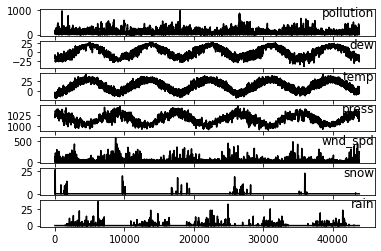

In [5]:
# generating dataset plot
from pandas import read_csv
from matplotlib import pyplot
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group],'k')
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [6]:
# Lets normalize all features, and remove the weather variables for the hour to be predicted.
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def s_to_super(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [7]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = s_to_super(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [8]:
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (8760, 1, 8) (8760,)  Testing data shape X, y =>  (35039, 1, 8) (35039,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [11]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adma version of stochastic gradient descent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,kernel_initializer='normal', activation='linear'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()

Epoch 1/50


ValueError: in user code:

    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/anaconda3/envs/Project/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 8)


In [10]:
# evaluating model
# make a prediction
from math import sqrt
from numpy import concatenate
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.446
